<a href="https://colab.research.google.com/github/AndrewArnett/DS-Unit-2-Kaggle-Challenge/blob/master/U2_S2_Kaggle_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [2]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [26]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [20]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [32]:
# Filtering Data
import numpy as np

def wrangle(X):
  
  X = X.copy()
  columns = ['quantity_group', 'num_private', 'amount_tsh', 'construction_year']

  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  
  cols_with_zeros = ['longitude', 'latitude', 'population', 'gps_height']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col] = X[col].replace(1, np.nan)

  X = X.drop(columns=columns, axis=1)

  return X  


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [33]:
# Creating Features
target = 'status_group'

train_features = train.drop(columns=[target, 'id'])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 125].index.tolist()

features = numeric_features + categorical_features

print(features)

['gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'basin', 'region', 'lga', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [40]:
# Arranging data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [41]:
#Creating pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe_model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=categorical_features),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(n_jobs=-1)
)

pipe_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'lga', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'permit', 'extraction_type',
                                     'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   

In [42]:
#Checking model accuracy on Training and Validation data
print('Training Accuracy', pipe_model.score(X_train, y_train))
print('Validation Accuracy', pipe_model.score(X_val, y_val))

Training Accuracy 0.75128367003367
Validation Accuracy 0.7494107744107744


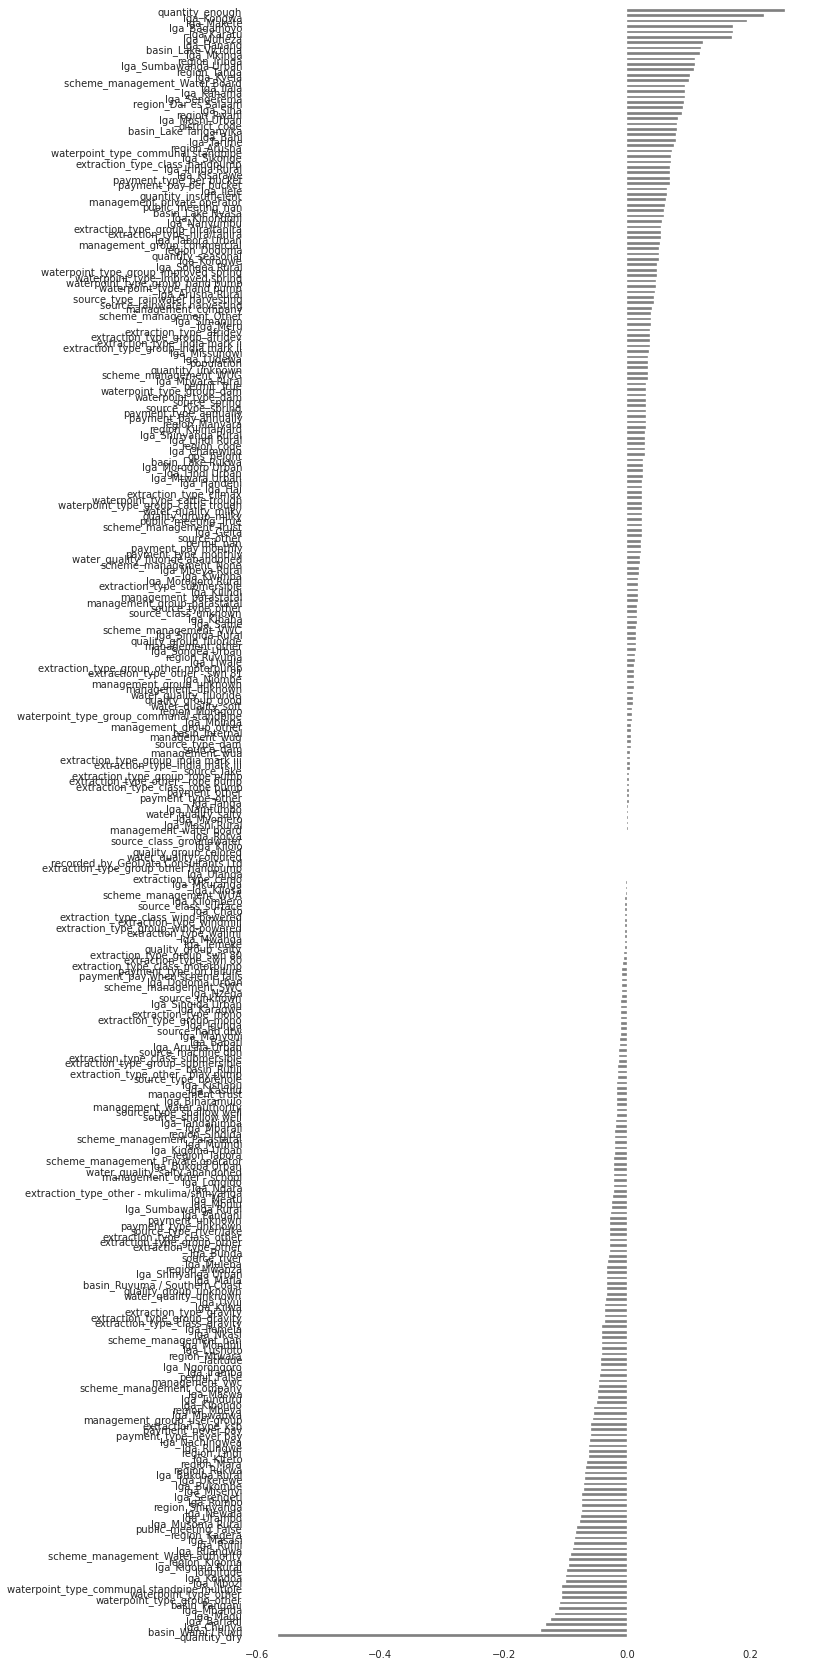

In [44]:
#Plotting coefficients
%matplotlib inline
import matplotlib.pyplot as plt

model = pipe_model.named_steps['logisticregression']
encoder = pipe_model.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [48]:
#Using decision Tree
from sklearn.tree import DecisionTreeClassifier

dt_model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42, max_depth=5)
)

dt_model.fit(X_train, y_train);

In [56]:
# Decision tree accuracy
print('Training Accuracy', dt_model.score(X_train, y_train))
print('Validation Accuracy', dt_model.score(X_val, y_val))

Training Accuracy 0.7106902356902357
Validation Accuracy 0.7124579124579125


In [60]:
y_pred = pipe_model.predict(X_test)

y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [69]:
sample_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [70]:
sample_submission['status_group'] = y_pred

In [71]:
sample_submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [78]:
sample_submission.to_csv('submission_1.csv', index=False)